In [1]:
#Import necessary libraries
import numpy as np
import glob
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
#Reading images from train dataset
path = glob.glob("dataset/train_1/*.jpg")
train_batch = []
for img in path:
    n = cv2.imread(img)
    train_batch.append(n)

In [3]:
print(len(train_batch))

1501


In [4]:
#Reading images from test dataset
path = glob.glob("dataset/test_1/*.jpg")
test_batch = []
for img in path:
    n = cv2.imread(img)
    test_batch.append(n)

In [5]:
print(len(test_batch))

690


In [6]:
#Converting the traning image list into NumPy array
train_batch = np.array(train_batch, dtype=np.float32)

In [7]:
#Converting the testing image list into NumPy array
test_batch = np.array(test_batch, dtype=np.float32)

In [8]:
#Dividing the training matrix by 255
train_batch = train_batch / 255.

In [9]:
#Dividing the testing matrix by 255
test_batch = test_batch / 255.

In [10]:
print(type(test_batch),type(test_batch))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [11]:
print(train_batch.shape,test_batch.shape)

(1501, 512, 512, 3) (690, 512, 512, 3)


In [12]:
#Designing the encoder model
input_img = Input(shape=(512,512,3))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

In [13]:
#Designing the decoder model
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [14]:
#Creating and compiling the model using mean squared error loss function
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [15]:
# Get the summary of the Model
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 64, 64, 8)         0     

In [16]:
#Save the model 
autoencoder.save('autoencoder.h5')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 64, 64, 8)         0     

In [18]:
#Save the encoder model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [19]:
encoder.save('encoder.h5')

(687, 512, 512, 3)

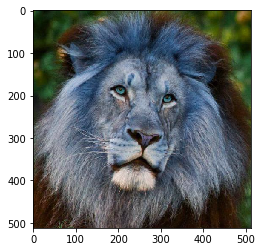

In [30]:
# Extract an image from the test dataset and print it
query = test_batch[5]
plt.imshow(query.reshape(512,512,3))
test_batch.shape
test_batch = np.delete(test_batch, 7, axis=0)
test_batch.shape

In [31]:
#Make predictions on test data
codes = encoder.predict(test_batch)
query_code = encoder.predict(query.reshape(1,512,512,3))
codes.shape
query_code.shape

(1, 64, 64, 8)

In [23]:
#Import KNN for clustering
from sklearn.neighbors import NearestNeighbors

In [32]:
#Get the shape of input image
codes = codes.reshape(-1, 64*64*8)
print(codes.shape)
query_code = query_code.reshape(1, 64*64*8)
print(query_code.shape)

(687, 32768)
(1, 32768)


(10, 512, 512, 3)


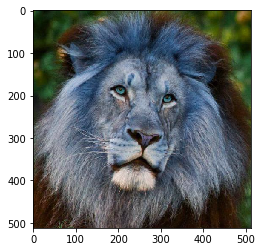

In [33]:
#Instantiate the KNN with 10 neighbours
nbrs = NearestNeighbors(n_neighbors=10).fit(codes)
distances, indices = nbrs.kneighbors(np.array(query_code))
closest_images = test_batch[indices]
closest_images = closest_images.reshape(-1,512,512,3); print(closest_images.shape)
plt.imshow(query.reshape(512,512,3), cmap='brg')

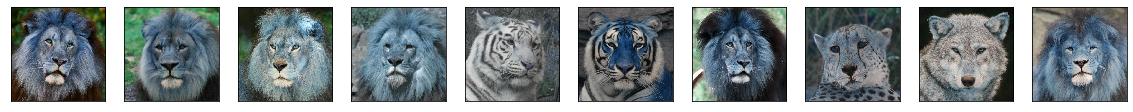

In [34]:
#Print the images clustered together
n_neighbors=10
plt.figure(figsize=(20, 10))
for i in range(n_neighbors):
    ax = plt.subplot(1, n_neighbors, i+1)
    plt.imshow(closest_images[i].reshape(512, 512,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()